# 1. Problem formulation

In this notebook, we are going to learn how to solve a (two-layer) deep Gaussian process (DGP) regression problem of the form

$$
\begin{equation}
\begin{split}
    U(t) &\sim \mathrm{GP}(0, C(t, t'; \ell(t), \sigma(t))),\\
    U_2(t) &\sim \mathrm{GP}(0, C_{\mathrm{Mat.}}(t, t'; \ell_2, \sigma_2),\\
    U_3(t) &\sim \mathrm{GP}(0, C_{\mathrm{Mat.}}(t, t'; \ell_3, \sigma_3), \\
    Y_k &= U(t_k) + \xi_k, \quad \xi_k \sim N(0, R_k),
   \end{split}\tag{1}
\end{equation}
$$

where $U \colon [0,\infty] \to \mathbb{R}$ is conditionally a GP, and $U_2 \colon [0,\infty] \to \mathbb{R}$ and $U_3 \colon [0,\infty] \to \mathbb{R}$ are two Matern 1/2 GPs. Although it's going to sound confusing, we are going to let $U$ be a *Matern 3/2*-like GP (conditioned on $U_2$ and $U_3$). The covariance function $C$ of $U$ is not given explictly but instead implied by a state-space formulation which we shall detail later. Moreover, we use $U_2$ and $U_3$ to parametrise the length scale and magnitude parameters of $U$, respectively. This is done by letting

$$
\ell(t) = g(U_2(t)), \quad \text{and} \quad \sigma(t) = g(U_3(t)),
$$

where $g\colon \mathbb{R} \to \mathbb{R}_{>0}$ is a positive transformation function (e.g., in the following we pick $g(u)=\exp(u)$).

The model above is a special case of parametrisation-based DGPs. We assume that we observe $U$ through additive Gaussian noises $\lbrace \xi_k\colon k=1,2,\ldots \rbrace$ giving measurements $\lbrace Y_k\colon k=1,2,\ldots \rbrace$. The aim is to learnt the joint posterior density of $U(t_k), U_2(t_k)$, and $U_3(t_k)$ from data for $k=1,2,\ldots$. 

# 2. State-space DGPs
The essence of state-space DGP (SS-DGP) methods consist in representing DGPs into their state-space forms. More specifically, the regression model above can be equivalently rewritten as a continous-discrete state-space model 

$$
\begin{equation}
\begin{split}
    d \overline{U}(t) &= A\big(U_2(t)\big) \, \overline{U}(t) \, dt + B\big(U_2(t), U_3(t)\big) \, dW(t),\\
    d U_2(t) &= A_2 \, U_2(t) \, dt + B_2 \, dW_2(t),\\
    d U_3(t) &= A_3 \, U_3(t) \, dt + B_3 \, dW_3(t),\\
    Y_k &= H \, V(t_k) + \xi_k, \quad \xi_k \sim N(0, R_k),
   \end{split}\tag{2}
\end{equation}
$$

where 

$$
\begin{aligned}
\overline{U}(t) &= \begin{bmatrix}U(t) & \frac{d U}{dt}(t)\end{bmatrix}^\top \in \mathbb{R}^2, \\
V(t) &= \begin{bmatrix}\overline{U}(t) & U_2(t) & U_3(t)\end{bmatrix}^\top \in \mathbb{R}^4,
\end{aligned}
$$

and $H\in\mathbb{R}^{4}$ is chosen such that $U(t) = H \, V(t)$ for all $t\in[0,\infty]$. (essentially $H=\begin{bmatrix}1 & 0 & 0 & 0\end{bmatrix}$). Wiener processes $W$, $W_2$, and $W_3$ are scalar-valued and are mutually independent. We let the initial condition follow $V(t_0) \sim N(m_0, P_0)$.

So, how do we determine the SDE coefficients $A, B, A_2, B_2, A_3, B_3$ above, so that the state variables correpsond to the conditional Matern GPs in Equation 1? Zhao (2020, 2021) show that they can be given as follows.

$$
A(U_2(t)) = 
\begin{bmatrix}
0 & 1\\
-\big(\frac{\sqrt{3}}{g(U_2(t))}\big)^2 & -2\,\frac{\sqrt{3}}{g(U_2(t))}
\end{bmatrix}, \quad B(U_2(t), U_3(t)) = 
\begin{bmatrix}
0 \\
2 \, g(U_3(t)) \, \big(\frac{\sqrt{3}}{g(U_2(t))}\big)^{3/2}
\end{bmatrix},
$$

and $A_2 = -1/\ell_2$, $B_2=\sqrt{2} \, \sigma_2 / \sqrt{\ell_2}$, $A_3 = -1/\ell_3$, and $B_3=\sqrt{2} \, \sigma_3 / \sqrt{\ell_3}$. 

Now, the DGP regression problem is a continuous-discrete filtering and smoothing problem, and we can solve it in linear time computational complexity (w.r.t. time) by leverating the Markov property of the SS-DGP. 

# 3. Model implementation

Okay, let's stop the bullshit and start to code it!

First, you need to install the dependencies in `requirements.txt`. You could manually install them by `pip install -r requirements.txt`. But please note that this will also install `tensorflow` and `goflow` which you might want to skip if don't want to compare against standard GP methods.

In [1]:
import math
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import tme.base_jax as tme
import time
from jax import jit, lax, jacfwd
from jax.config import config
from typing import Callable, Tuple
from filters_smoothers import ekfs, simulate_sample_normal_inc_diag

# I always insist to use float64 whenever possible.
config.update("jax_enable_x64", True)

Let us write down the SDEs. In the below, functions `drift()` and `dispersion()` correspond to the drift and dispersion parts of the SDE system in Equation 2.

In [2]:
ell_2 = 0.05
sigma_2 = 1.5
ell_3 = 0.05
sigma_3 = 1.5

def g(u): return jnp.exp(u)

# This parameter and g3 will be explained later.
base_sigma_t_val = 0.
def g3(u): return jnp.exp(u + base_sigma_t_val)

@jit
def drift(u: jnp.ndarray) -> jnp.ndarray:
    kappa = math.sqrt(3) / g(u[2])
    return jnp.array([[0., 1., 0., 0.],
                      [-(kappa ** 2), -2 * kappa, 0., 0.],
                      [0., 0., -1 / ell_2, 0.],
                      [0., 0., 0., -1 / ell_3]]) @ u

Qw = jnp.eye(3)

@jit
def dispersion(u: jnp.ndarray):
    return jnp.array([[0., 0., 0.],
                      [2 * g3(u[3]) * (math.sqrt(3) / g(u[2])) ** 1.5, 0., 0.],
                      [0., math.sqrt(2) * sigma_2 / math.sqrt(ell_2), 0.],
                      [0., 0., math.sqrt(2) * sigma_3 / math.sqrt(ell_3)]])


H = jnp.array([[1., 0., 0., 0.]])

# Initial condition
m0 = jnp.array([0., 0., 0., -2])
P0 = 0.1 * jnp.eye(4)

Wait a sec, why is the initial mean of $U_3(t_0)$ deliberately set to -2? No worry, we will explain this around the end of the notebook.

# 4. Discretisation
Next, we need to solve the SDE. For simplicity, we here approximate the SDE in discrete time and Gaussian increments, so that we can immediately apply discrete-time non-linear filters and smoothers (e.g., extended Kalman filters and smoothers). More specifically, the solution of the SDE at time $t_{k+1}$ is approximated by

$$
V(t_{k+1}) \approx f(V(t_k)) + q(V(t_k)), \quad q(V(t_k)) \sim N(0, Q(V(t_k))),
$$

where functions $f$ and $Q$ are determined by the discretisation method used. This can be done by using Euler--Maruyama or other higher-order methods, such as [TME](https://github.com/zgbkdlm/tme). We code up these two methods as follows. In particular, the functions `disc_em` and `disc_tme` return the $f$ and $Q$ of Euler--Maruyama and TME, respectively.

In [3]:
@jit
def disc_em(u: jnp.ndarray, dt: float) -> Tuple[jnp.ndarray, jnp.ndarray]:
    d = dispersion(u)
    return u + drift(u) * dt, d @ Qw @ d.T * dt


@jit
def disc_tme(u: jnp.ndarray, dt: float) -> Tuple[jnp.ndarray, jnp.ndarray]:
    return tme.mean_and_cov(u, dt, drift, dispersion, Qw, order=3)

# 5. Samples from SS-DGP
Okay, the SDE have now been coded. Should we make a few samples from it and see how they behave? The sampling method is already coded in `simulate_sample_normal_inc_diag()` or `simulate_sample_normal_inc()`, where the former one assumes diagonal $Q$. Note that if you want to use Euler--Maruyama `disc_em()`, you should use `simulate_sample_normal_inc_diag()`, as the Euler--Maruyama method for this model gives singular $Q$ which cannot be Cholesky decomposed in `simulate_sample_normal_inc()`. If you want to use `disc_tme()`, then please use `simulate_sample_normal_inc()`.

In [4]:
# Let's make samples on t \in [0, 1] with 2000 time steps
ts = jnp.linspace(0, 1, 2000)
dts = jnp.diff(ts)

# Jax random key
key = jax.random.PRNGKey(666)

# Draw initial value
key, subkey = jax.random.split(key)
x0 = jax.random.multivariate_normal(key=subkey, mean=m0, cov=P0)

# Draw an SDE solution trajectory
key, subkey = jax.random.split(key)
dws = jax.random.normal(subkey, shape=(dts.size, x0.shape[0]))
sample = simulate_sample_normal_inc_diag(m_and_cov=disc_em,
                                         x0=x0, dts=dts, dws=dws)

Let's plot three samples from the SDE. From the figures below, it looks like the process $U$ exhibits strong non-stationary behavious driven by the changing length scale and magnitude parameters. You could keep ctrl+entering the plotting code block to generate and examine more samples.

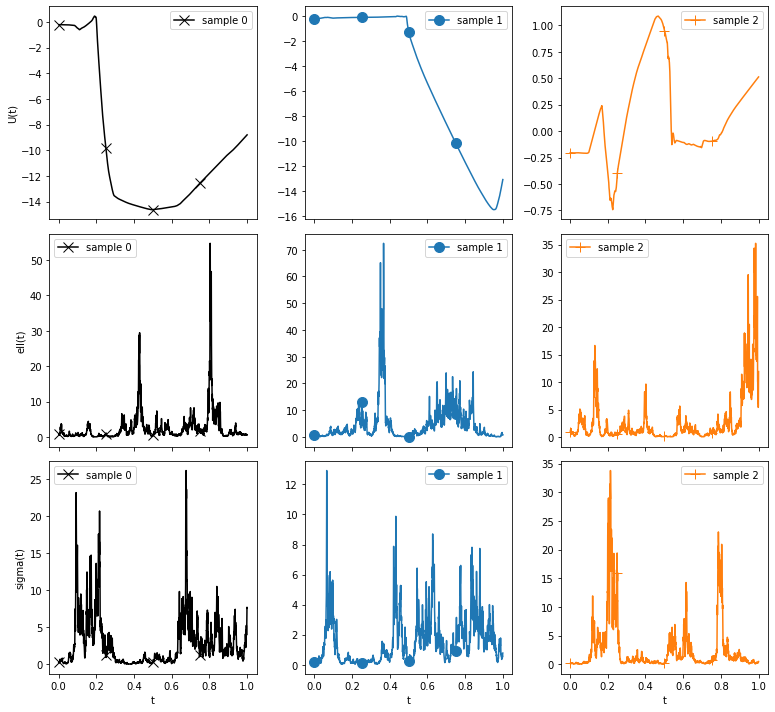

In [5]:
markers = ['x', 'o', '+']
colors = ['black', 'tab:blue', 'tab:orange']

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(11, 10), sharex=True)
ax[0, 0].set_ylabel('U(t)')
ax[1, 0].set_ylabel('ell(t)')
ax[2, 0].set_ylabel('sigma(t)')
ax[2, 0].set_xlabel('t')
ax[2, 1].set_xlabel('t')
ax[2, 2].set_xlabel('t')

for idx, marker, color in zip([0, 1, 2], markers, colors):
    key, subkey = jax.random.split(key)
    dws = jax.random.normal(subkey, shape=(dts.size, x0.shape[0]))
    sample = simulate_sample_normal_inc_diag(m_and_cov=disc_em,
                                             x0=x0, dts=dts, dws=dws)
    ax[0, idx].plot(ts[1:], sample[:, 0], c=color, 
                    marker=marker, markevery=500, markersize=10, label=f'sample {idx}')
    ax[0, idx].legend()
    ax[1, idx].plot(ts[1:], g(sample[:, 2]), c=color, 
                    marker=marker, markevery=500, markersize=10, label=f'sample {idx}')
    ax[1, idx].legend()
    ax[2, idx].plot(ts[1:], g(sample[:, 3]), c=color, 
                    marker=marker, markevery=500, markersize=10, label=f'sample {idx}')
    ax[2, idx].legend()

plt.tight_layout()

# 6. Regression on a toymodel

By inspecting the samples from the SDE prior, we guess that this prior may be suitable for a large class of challenging signals/functions. As an exanple, let us consider the following toy data-generating model

$$
f(t) = \frac{\sin(7 \, \pi \cos(2 \, \pi \, t^2) \, t)^2}{\cos(5 \pi \, t) + 2}, \quad t \in [0, 1].
$$

This composite sinusoidal signal is challenging in the sense that it has a frequency-changing characteristic. The signal may not be easy for conventional GPs to capture. 

Let us generate a signal and a measurement (with measurement noise variance $R=0.01$) from this toymodel.

In [6]:
def toymodel_sin(ts: jnp.ndarray, noise_var: float, key: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Return the composite sine signal and a noisy measurement of it.
    """
    signal = jnp.sin(7 * math.pi * jnp.cos(2 * math.pi * ts ** 2)) ** 2 \
           / (jnp.cos(5 * math.pi * ts) + 2)
    return signal, signal + math.sqrt(noise_var) * jax.random.normal(key, shape=ts.shape)

key, subkey = jax.random.split(key)
measurement_var = 0.01
signal, y = toymodel_sin(ts, measurement_var, subkey)

The signal and measurement look like this:

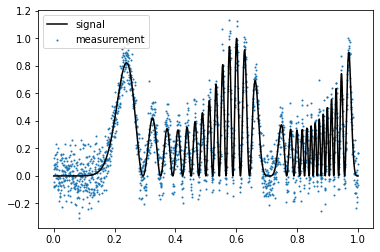

In [7]:
plt.plot(ts, signal, c='black', label='signal')
plt.scatter(ts, y, s=1, label='measurement')
plt.legend()

Okay, now we can try to solve the SS-DGP regression problem with the data above. 

The filtering and smoothing solver we use here is a standard extended Kalman filter and smoother (EKFS). These are very easy to implement, and their codes are given in `filters_smoothers.py` and tested in `test_fs.py`. You just need to feed a function that returns $f$ and $Q$, and feed the initial condition and data. Here we use `disc_em`.

In [8]:
@jit
def jitted_filter_smoother(data):
    return ekfs(f_Q=disc_em, H=H, R=measurement_var,
                m0=m0, P0=P0, dts=dts, ys=data)
_, _ = jitted_filter_smoother(y[1:])

tic = time.time()
_, smoothing = jitted_filter_smoother(y[1:])
ekfs_time = time.time() - tic

# These are our regression posterior mean and covariance.
posterior_mean = smoothing[0]
posterior_cov = smoothing[1]

In [9]:
print(f'SS-DGP regression (using EKFS) takes {ekfs_time} seconds over {y[1:].size} time steps')

SS-DGP regression (using EKFS) takes 0.008415937423706055 seconds over 1999 time steps


Now let us plot the regression fit.

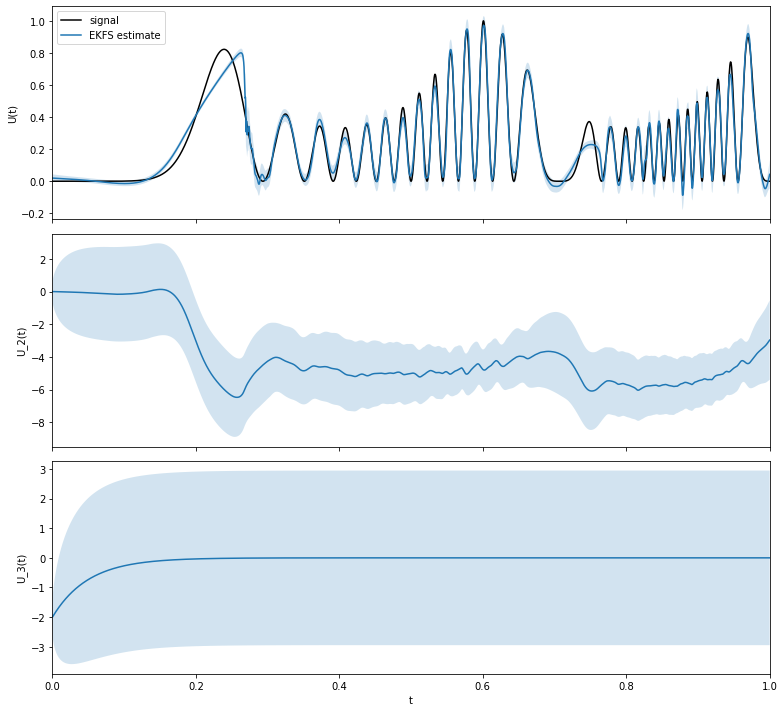

In [10]:
fig, ax = plt.subplots(nrows=3, figsize=(11, 10), sharex=True)

ax[0].plot(ts, signal, c='black', label='signal')
ax[0].plot(ts[1:], posterior_mean[:, 0], c='tab:blue', label='EKFS estimate')
ax[0].fill_between(
        ts[1:],
        posterior_mean[:, 0] - 1.96 * jnp.sqrt(posterior_cov[:, 0, 0]),
        posterior_mean[:, 0] + 1.96 * jnp.sqrt(posterior_cov[:, 0, 0]),
        color='tab:blue',
        edgecolor='none',
        alpha=0.2,
)
ax[0].set_ylabel('U(t)')
ax[0].legend()

ax[1].plot(ts[1:], smoothing[0][:, 2], c='tab:blue', label='EKFS estimate')
ax[1].fill_between(
        ts[1:],
        posterior_mean[:, 2] - 1.96 * jnp.sqrt(posterior_cov[:, 2, 2]),
        posterior_mean[:, 2] + 1.96 * jnp.sqrt(posterior_cov[:, 2, 2]),
        color='tab:blue',
        edgecolor='none',
        alpha=0.2,
)
ax[1].set_ylabel('U_2(t)')

ax[2].plot(ts[1:], smoothing[0][:, 3], c='tab:blue', label='EKFS estimate')
ax[2].fill_between(
        ts[1:],
        posterior_mean[:, 3] - 1.96 * jnp.sqrt(posterior_cov[:, 3, 3]),
        posterior_mean[:, 3] + 1.96 * jnp.sqrt(posterior_cov[:, 3, 3]),
        color='tab:blue',
        edgecolor='none',
        alpha=0.2,
)
ax[2].set_xlabel('t')
ax[2].set_ylabel('U_3(t)')
ax[2].set_xlim(0, 1)

plt.tight_layout()

From the figure above, we find that the SS-DGP fit look fairly okay, and that the confidence interval of $U$ is also pretty reasonable. Moreover, the learnt length scale driving parameter $U_2$ is able to change as the frequency of the signal changes. This is the behavious that we intend to have!

But what happened to the estiamte of $U_3$? It looks like $U_3(t)$ somehow shrink to zero as $t\to \infty$ and do not use any information from the data at all. This is a so-called identifiablity problem pointed out in Zhao (2020, 2021). Essentially, roughly speaking, any Gaussian approximation-based filters and smoothers (e.g., EKFS or sigma-point) will fail to estimate the magnitude parameter $\sigma$ driving term $U_3$ (plus some assumptions on the measurement model also). We invite the reader to Zhao (2020, 2021) for more details. 

Due to this identifiability problem, the estimates of $U(t)$ are not good around $t\in[0.15, 0.3]$s, where you can find a large deviation from the true signal.

So, since the magnitude parameter cannot be reasonably learnt on this model, we shoud bypass it. This can be done by removing the $U_3$ component in the SDE model. However, since we don't want to change the code (i.e., I'm lazy), this purpose can also be done achieved without modifying the model: Simply set the initial mean of $U_3(t_0)$ to zero and make its transformation function has a baseline value as follows.

In [11]:
# We want \sigma(t) to stay at 1.5 for all t.
base_sigma_t_val = 1.5

# Set the initial mean to zeros
m0 = jnp.array([0., 0., 0., 0.])

Let's compile and run the EKFS again, and plot the new results with $U_3(t)$ fixed at 1.5 for all $t$.

In [12]:
@jit
def jitted_filter_smoother(data):
    return ekfs(f_Q=disc_em, H=H, R=measurement_var,
                m0=m0, P0=P0, dts=dts, ys=data)
filtering, smoothing = jitted_filter_smoother(y[1:])

posterior_mean = smoothing[0]
posterior_cov = smoothing[1]

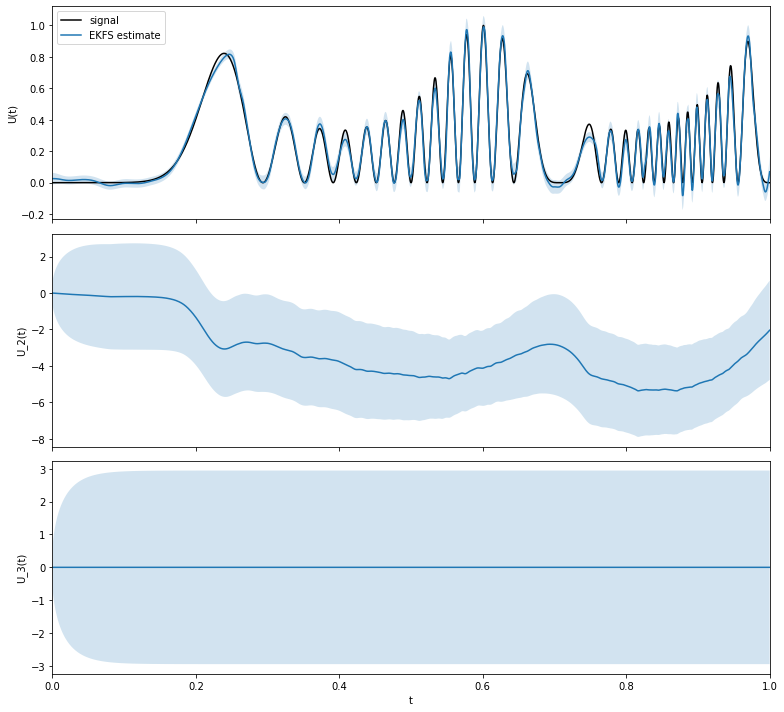

In [13]:
fig, ax = plt.subplots(nrows=3, figsize=(11, 10), sharex=True)
ax[0].plot(ts, signal, c='black', label='signal')
ax[0].plot(ts[1:], posterior_mean[:, 0], c='tab:blue', label='EKFS estimate')
ax[0].fill_between(
        ts[1:],
        posterior_mean[:, 0] - 1.96 * jnp.sqrt(posterior_cov[:, 0, 0]),
        posterior_mean[:, 0] + 1.96 * jnp.sqrt(posterior_cov[:, 0, 0]),
        color='tab:blue',
        edgecolor='none',
        alpha=0.2,
)
ax[0].set_ylabel('U(t)')
ax[0].legend()

ax[1].plot(ts[1:], smoothing[0][:, 2], c='tab:blue', label='EKFS estimate')
ax[1].fill_between(
        ts[1:],
        posterior_mean[:, 2] - 1.96 * jnp.sqrt(posterior_cov[:, 2, 2]),
        posterior_mean[:, 2] + 1.96 * jnp.sqrt(posterior_cov[:, 2, 2]),
        color='tab:blue',
        edgecolor='none',
        alpha=0.2,
)
ax[1].set_ylabel('U_2(t)')

ax[2].plot(ts[1:], smoothing[0][:, 3], c='tab:blue', label='EKFS estimate')
ax[2].fill_between(
        ts[1:],
        posterior_mean[:, 3] - 1.96 * jnp.sqrt(posterior_cov[:, 3, 3]),
        posterior_mean[:, 3] + 1.96 * jnp.sqrt(posterior_cov[:, 3, 3]),
        color='tab:blue',
        edgecolor='none',
        alpha=0.2,
)
ax[2].set_xlabel('t')
ax[2].set_ylabel('U_3(t)')
ax[2].set_xlim(0, 1)

plt.tight_layout()

Yep, that's it. The results look much better, right? You can also check that `g3(U_3(t))` should also stay at set 1.5.

Exercises: 

1. Try build a Matern SS-DGP model by yourself without $\sigma(t)$.

2. Try using a different solvers such as sigma-point filters and smoothers.

3. Try estimate the parameters $\ell_2$ and $\sigma_2$ by minimising the negative log-likelihood (of EKFS). See, e.g., Sarkka (2013) for how to derive the log-likelihood.

----------------------------------------------
# 7. Compare with standard GPs

Below is optional, and it requires you install `gpflow`.

How about comparing this Matern SS-DGP against other GPs, such as conventional stationary GPs? To do so, we are going to use `gpflow` which require you to install `tensorflow` and `gpflow`.

In [14]:
import gpflow as gpf
import tensorflow as tf
import gpflow.kernels

In [15]:
# We use these covariance functions
m12 = gpf.kernels.Matern12()
m32 = gpf.kernels.Matern32()
m52 = gpf.kernels.Matern52()
rbf = gpf.kernels.SquaredExponential()

# data
data_x = tf.reshape(tf.constant(ts[1:]), (-1, 1))
data_y = tf.reshape(tf.constant(y[1:]), (-1, 1))

# container for saving the models and results
all_models = []
posterior_results = []

2021-08-19 14:32:23.025467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2021-08-19 14:32:23.025537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2021-08-19 14:32:23.025594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-08-19 14:32:23.025648: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2021-08-19 14:32:23.025766: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Canno

In [16]:
for cov in (m12, m32, m52, rbf):
    gp_model = gpf.models.GPR(data=(data_x, data_y), kernel=cov, mean_function=None)
    
    opt = gpf.optimizers.Scipy()
    tic = time.time()
    opt_logs = opt.minimize(gp_model.training_loss, gp_model.trainable_variables, options=dict(maxiter=100))
    opt_time = time.time() - tic
    print(f'GP ({cov._name}) parameter learning takes {opt_time} seconds over {ts[1:].size} time steps')
    
    _, _ = gp_model.predict_f(data_x)
    tic = time.time()
    mean, var = gp_model.predict_f(data_x)
    pred_time = time.time() - tic
    print(f'GP ({cov._name}) prediction takes {pred_time} seconds over {ts[1:].size} time steps')
    
    all_models.append(gp_model)
    posterior_results.append((mean, var))

2021-08-19 14:32:23.077536: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


GP (matern12) parameter learning takes 35.82374548912048 seconds over 1999 time steps
GP (matern12) prediction takes 0.9383950233459473 seconds over 1999 time steps
GP (matern32) parameter learning takes 66.97929573059082 seconds over 1999 time steps
GP (matern32) prediction takes 0.9822571277618408 seconds over 1999 time steps
GP (matern52) parameter learning takes 32.434547901153564 seconds over 1999 time steps
GP (matern52) prediction takes 1.0212185382843018 seconds over 1999 time steps
GP (squared_exponential) parameter learning takes 42.43801927566528 seconds over 1999 time steps
GP (squared_exponential) prediction takes 0.9298596382141113 seconds over 1999 time steps


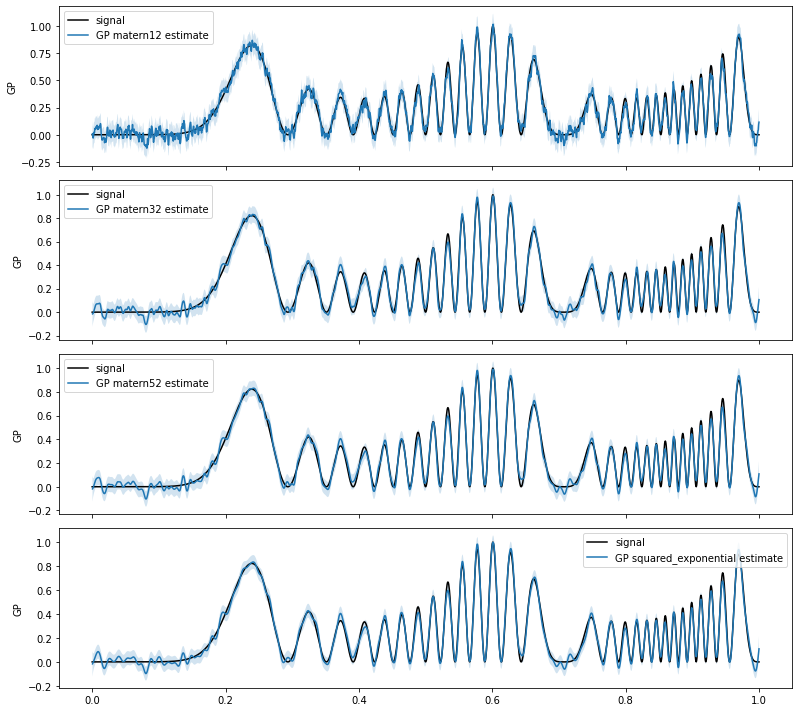

In [17]:
fig, ax = plt.subplots(nrows=4, figsize=(11, 10), sharex=True)

for gp_idx in range(4):
    
    gp_mean, gp_var = posterior_results[gp_idx]

    ax[gp_idx].plot(ts, signal, c='black', label='signal')
    ax[gp_idx].plot(data_x[:, 0], gp_mean[:, 0], c='tab:blue', label=f'GP {all_models[gp_idx].kernel._name} estimate')
    ax[gp_idx].fill_between(
            ts[1:],
            gp_mean[:, 0] - 1.96 * tf.sqrt(gp_var[:, 0]),
            gp_mean[:, 0] + 1.96 * tf.sqrt(gp_var[:, 0]),
            color='tab:blue',
            edgecolor='none',
            alpha=0.2,
    )
    ax[gp_idx].set_ylabel('GP')
    ax[gp_idx].legend()


plt.tight_layout()

We can see that these stationary GPs somehow over-adpat the high-frequency section (please check their learnt parameters and you will see) of the signal. This makes them poorly fit the low-frequency section (i.e., $t\leq 0.3$ s) of the signal.

Numerically, the RMSE are:

In [18]:
def rmse(backend, x, y):
    try:
        return backend.sqrt(backend.mean((x - y) ** 2))
    except:
        return backend.sqrt(backend.reduce_mean((x - y) ** 2))

print(f'RMSE of SS-DGP (EKFS) is {rmse(jnp, posterior_mean[:, 0], signal[1:])}')
print(f'RMSE of GP Matern 1/2 is {rmse(tf.math, posterior_results[0][0][:, 0], signal[1:])}')
print(f'RMSE of GP Matern 3/2 is {rmse(tf.math, posterior_results[1][0][:, 0], signal[1:])}')
print(f'RMSE of GP Matern 5/2 is {rmse(tf.math, posterior_results[2][0][:, 0], signal[1:])}')
print(f'RMSE of GP RBF is {rmse(tf.math, posterior_results[3][0][:, 0], signal[1:])}')

RMSE of SS-DGP (EKFS) is 0.027352625618646063
RMSE of GP Matern 1/2 is 0.04239056636655371
RMSE of GP Matern 3/2 is 0.03320475018472418
RMSE of GP Matern 5/2 is 0.031761026012641004
RMSE of GP RBF is 0.029938136408470345


# Bibliography

Thank you for following this notebook. For more details of SS-DGP models and methods, we refer the reader to the following articles/thesis. 

Zheng Zhao. State-space deep Gaussian processes. PhD thesis, Aalto University, 2021.

Zheng Zhao, Muhammad Emzir, and Simo Särkkä. Deep state-space Gaussian processes. Statistics and Computing, 2021, in press.